In [1]:
from tensorflow import keras

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary
from torchmetrics.regression import *
from torchmetrics.classification import *
from torchmetrics.functional.regression import r2_score
from torchmetrics.functional.classification import f1_score

In [2]:
(train_input, train_target), (test_input, test_target) = keras.datasets.fashion_mnist.load_data()

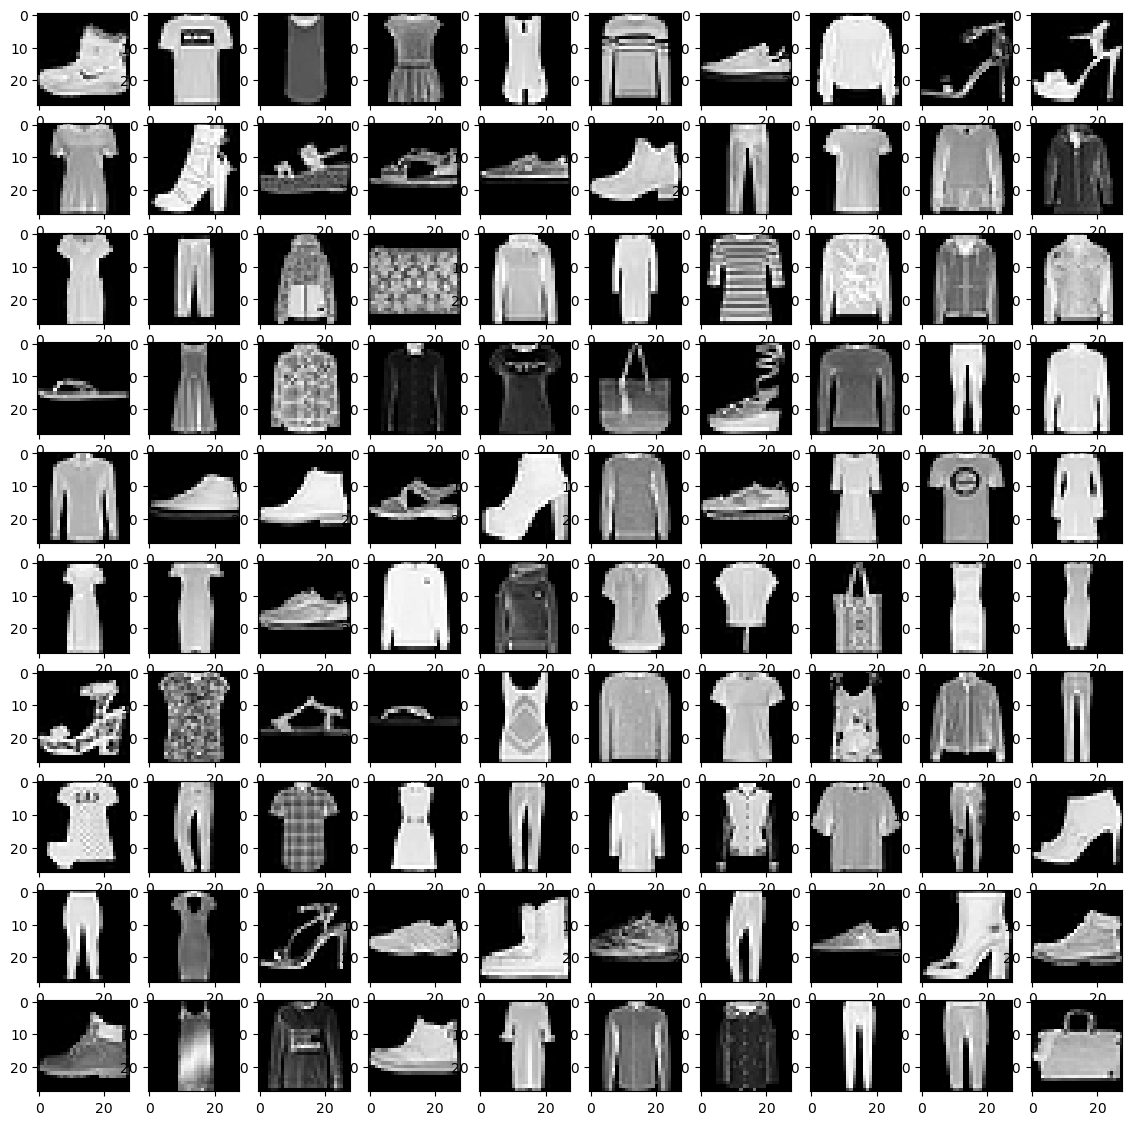

In [3]:
fig, axs = plt.subplots(10,10, figsize = (14, 14))

for i in range(10):
    for j in range(10):
        axs[i][j].imshow(train_input[i*10+j].reshape(28,28), cmap='gray')
plt.show()

In [4]:
torch.manual_seed(1) # 시드 설정

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'DEVICE : {DEVICE}')

DEVICE : cpu


In [5]:
# train, valid, test 분리
train_input, valid_input, train_target, valid_target = train_test_split(train_input, train_target,
                                                                        train_size = 0.8,
                                                                        stratify = train_target,
                                                                        random_state = 42)

In [6]:
print(f"[train] input : {train_input.shape}, target : {train_target.shape}")
print(f"[valid] input : {valid_input.shape}, target : {valid_target.shape}")
print(f"[test] input : {test_input.shape}, target : {test_target.shape}")

[train] input : (48000, 28, 28), target : (48000,)
[valid] input : (12000, 28, 28), target : (12000,)
[test] input : (10000, 28, 28), target : (10000,)


In [7]:
train_inputDF = pd.DataFrame((train_input/255).reshape(train_input.shape[0],-1))
train_targetDF = pd.DataFrame(train_target.copy().reshape(-1,1))
valid_inputDF = pd.DataFrame((valid_input/255).reshape(valid_input.shape[0],-1))
valid_targetDF = pd.DataFrame(valid_target.copy().reshape(-1,1))
test_inputDF = pd.DataFrame((test_input/255).reshape(test_input.shape[0],-1))
test_targetDF = pd.DataFrame(test_target.copy().reshape(-1,1))

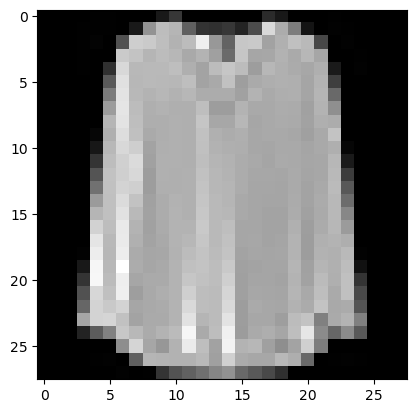

In [8]:
plt.imshow(train_inputDF.iloc[0,:].values.reshape(28,-1), cmap='gray')

In [9]:
print(f"train_input : {train_inputDF.shape}, train_target : {train_targetDF.shape}")
print(f"valid_input : {valid_inputDF.shape}, valid_target : {valid_targetDF.shape}")
print(f"test_input : {test_inputDF.shape}, test_target : {test_targetDF.shape}")

train_input : (48000, 784), train_target : (48000, 1)
valid_input : (12000, 784), valid_target : (12000, 1)
test_input : (10000, 784), test_target : (10000, 1)


In [10]:
# 데이터셋 생성
from DataSet import CustomDataset

trainDS = CustomDataset(train_inputDF, train_targetDF)
validDS = CustomDataset(valid_inputDF, valid_targetDF)

# 데이터셋 속성
print(f"trainDS shape : ({trainDS.n_rows}, {trainDS.n_features})")
print(f"testDS : ({validDS.n_rows}, {validDS.n_features})")

# 데이터로더 인스턴스 생성
trainDL = DataLoader(trainDS, batch_size=32)
validDL = DataLoader(validDS, batch_size=32)

trainDS shape : (48000, 784)
testDS : (12000, 784)


In [11]:
# 모델 인스턴스 생성
from CustomModel import DeepModel

model = DeepModel(input_in=784, output_out=10, hidden_list=[100, 80, 60, 40, 20],
                  act_func=F.relu, is_reg=False, is_bin=False)
print(model)
summary(model)

DeepModel(
  (input_layer): Linear(in_features=784, out_features=100, bias=True)
  (hidden_layer_list): ModuleList(
    (0): Linear(in_features=100, out_features=80, bias=True)
    (1): Linear(in_features=80, out_features=60, bias=True)
    (2): Linear(in_features=60, out_features=40, bias=True)
    (3): Linear(in_features=40, out_features=20, bias=True)
  )
  (output_layer): Linear(in_features=20, out_features=10, bias=True)
)


Layer (type:depth-idx)                   Param #
DeepModel                                --
├─Linear: 1-1                            78,500
├─ModuleList: 1-2                        --
│    └─Linear: 2-1                       8,080
│    └─Linear: 2-2                       4,860
│    └─Linear: 2-3                       2,440
│    └─Linear: 2-4                       820
├─Linear: 1-3                            210
Total params: 94,910
Trainable params: 94,910
Non-trainable params: 0

In [12]:
for feature, target in trainDL:
    print(feature, target, sep='\n')
    break

tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.1451, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]])
tensor([[6.],
        [6.],
        [3.],
        [3.],
        [0.],
        [5.],
        [9.],
        [3.],
        [6.],
        [1.],
        [7.],
        [8.],
        [8.],
        [9.],
        [6.],
        [9.],
        [7.],
        [4.],
        [8.],
        [2.],
        [2.],
        [2.],
        [1.],
        [2.],
        [2.],
        [1.],
        [4.],
        [0.],
        [4.],
        [3.],
        [4.],
        [4.]])


In [15]:
# 옵티마이저 (모델의 가중치 절편 최적화)
adam_optim = optim.Adam(model.parameters(), lr=0.00001)
# 가중치, 절편을 전달하고 학습률을 설정

# 모델 훈련
from TorchTrainTest import training, testing
EPOCH = 1
result = training(trainDL, validDL, model, 'multiclass',
                  adam_optim, EPOCH, num_classes=10)

[Loss : 1/1] Train : 2.2481, Test : 2.0303
[Score  : 1/1] Train : 0.1280, Test : 0.2657


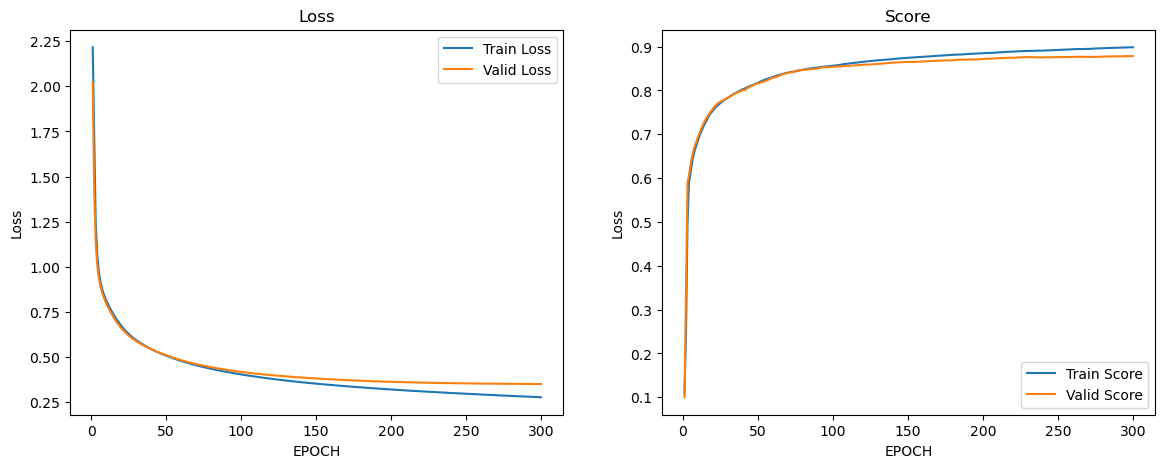

In [26]:
fig, axs = plt.subplots(1, 2, figsize = (14, 5))

label_list = ['Loss', 'Score']

for i in range(2):
    axs[i].plot(range(1, EPOCH+1), result[2*i], label = f'Train {label_list[i]}')
    axs[i].plot(range(1, EPOCH+1), result[2*i+1], label = f'Valid {label_list[i]}')
    axs[i].set_title(label_list[i])
    axs[i].set_xlabel('EPOCH')
    axs[i].set_ylabel('Loss')
    axs[i].legend()
plt.show()

In [28]:
# 최종 훈련된 모델 저장
torch.save(model.state_dict(), 'model_fashion_mnist.pth') # 모델 파라미터를 저장하는 경우
torch.save(model, 'model.pth') # 모델 자체를 저장하는 경우

In [34]:
# 저장한 모델 불러오기
model.load_state_dict(torch.load('model_fashion_mnist.pth',
                                 weights_only=True)) # 모델 파라미터를 불러오는 경우

<All keys matched successfully>

In [35]:
# 평가를 위한 테스트 데이터셋 생성
from DataSet import CustomDataset

testDS = CustomDataset(test_inputDF, test_targetDF)
testDL = DataLoader(testDS, batch_size = 32)

In [36]:
# 테스트 진행
from TorchTrainTest import training, testing
test_result = testing(testDL, model, is_reg=False, is_bin=False, num_classes=10)

In [39]:
print(f"Test Loss : {test_result[0]:.4f}, Test Score : {test_result[1]:.4f}")

Test Loss : 0.3510, Test Score : 0.8784


In [46]:
testDL.dataset[0][0].shape

torch.Size([784])

- 0 T-shirt/top
- 1 Trouser
- 2 Pullover
- 3 Dress
- 4 Coat
- 5 Sandal
- 6 Shirt
- 7 Sneaker
- 8 Bag
- 9 Ankle boot

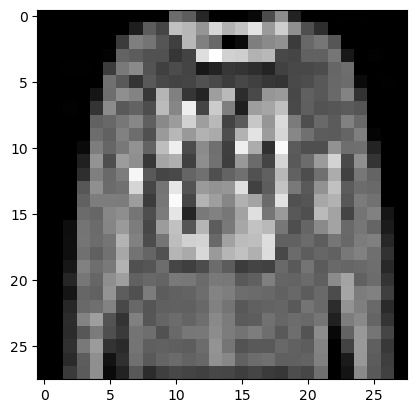

label : 2


In [56]:
plt.imshow(test_input[500], cmap='gray')
plt.show()
print(f"label : {test_target[500]}")

In [82]:
test_inputTS = torch.FloatTensor(test_inputDF.values)

input_sample = test_inputTS[500].reshape(1,-1) # 모델에 입력할 때 일반적으로 2차원 텐서로 전달

# 예측 수행
torch.argmax(model(input_sample), dim=1) # dim=1을 해야 여러개의 행이 들어왔을 때 행 별로 계산됨

tensor([2])

실제 레이블인 2(Pullover)와 모델의 예측값인 2가 일치한다.